In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [0]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
# Import the necessary libraries 
import numpy as np
import matplotlib.pyplot as plt

# leNet
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

# data initialization
import pickle
import pandas as pd

import random

In [0]:
np.random.seed(0)

# Data

## Data Initialisation

In [0]:
with open('german-traffic-signs/train.p', mode='rb') as f:
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p', mode='rb') as f:
  val_data = pickle.load(f)

with open('german-traffic-signs/test.p', mode='rb') as f:
  test_data = pickle.load(f)

In [0]:
print(type(train_data))

<class 'dict'>


In [0]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


In [0]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


## Data validation

In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"

assert(X_train.shape[1:] == (32, 32, 3)), "The dimension of the images are not 32x32x3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimension of the images are not 32x32x3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimension of the images are not 32x32x3"

## Data visualisation

In [0]:
label_names = pd.read_csv('german-traffic-signs/signnames.csv')
print(label_names)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

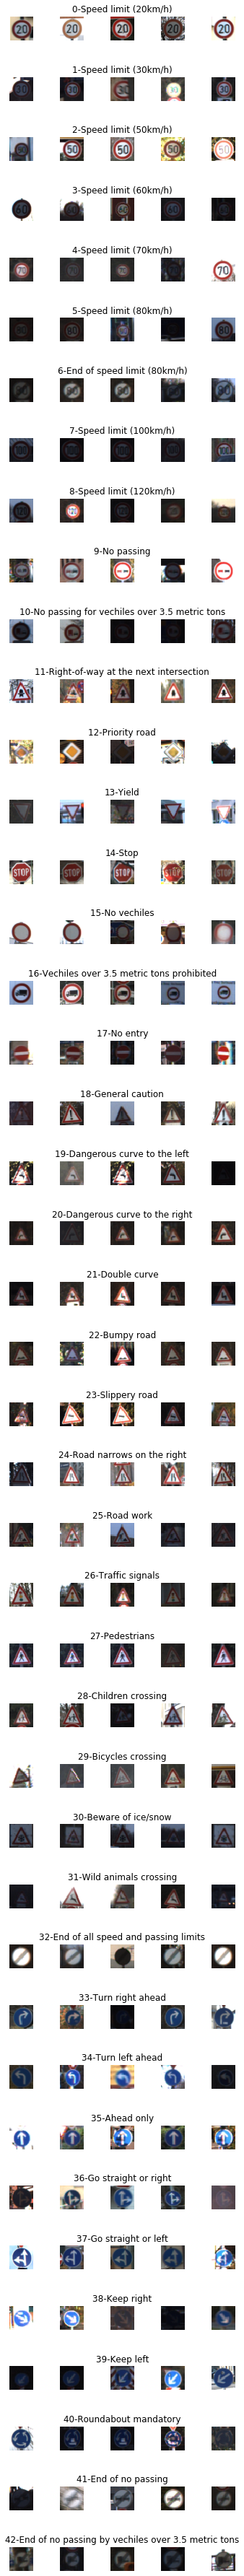

In [0]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in label_names.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-' + row['SignName'])
            num_of_samples.append(len(x_selected))


## Data distribution visualisation

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

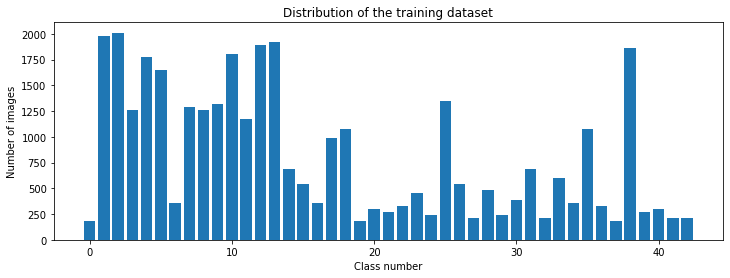

In [0]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

## Data preprocessing

In [0]:
import cv2

Original shape: (32, 32, 3) before preprocessing.
36


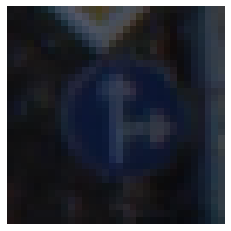

In [0]:
plt.imshow(X_train[1000])
plt.axis('off')
print('Original shape:', X_train[1000].shape, 'before preprocessing.')
print(y_train[1000])

In [0]:
def gray_scale(img):
  return (cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
  # as color is not a very distintive feature of traffic signs. Plus a gray scale img will reduce the depth of the input imgs reducing the computation need


(32, 32)


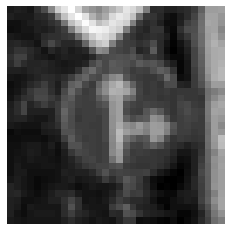

In [0]:
img = gray_scale(X_train[1000])
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

In [0]:
def equalize(img):
  return (cv2.equalizeHist(img))

  # Equalising the histogram genarlise the pixel value intensities more evenly ensure no single high frequency pixel has dominane during training

(-0.5, 31.5, 31.5, -0.5)

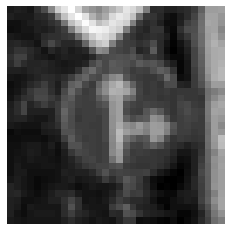

In [0]:
equalize(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis('off')

In [0]:
def preprocessing(img):
  img = equalize(gray_scale(img))
  img = img/255 # Normalise
  return img

X_train = np.array(list(map(preprocessing, X_train))) # each image inputed into preprocessing() and then returned as a list 
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

Dimensions After: (34799, 32, 32)


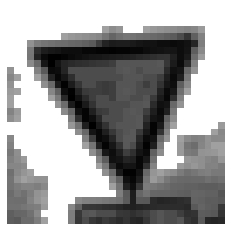

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap='gray')
plt.axis('off')
print('Dimensions After:', X_train.shape)

### Reshaping the input to have single channel

In [0]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


## Data Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(width_shift_range = 0.1,
                   height_shift_range = 0.1, 
                   zoom_range = 0.2,
                   shear_range = 0.1, 
                   rotation_range = 10)

data_gen.fit(X_train)

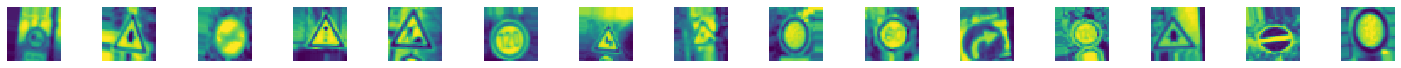

In [0]:
batches = data_gen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axis = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
  axis[i].imshow(X_batch[i].reshape(32, 32))
  axis[i].axis('off')

In [0]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


### One Hot Encoding

In [0]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

# LeNet Neural Network

In [0]:
def modified_leNet_model():
  model = Sequential()

  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2))) # downscale

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2)))
  # model.add(Dropout(0.5)) # another drop out layer to decrease overfitting, No longer needed as we solved this issue by increasing the number of images using the ImageDataGenerator 

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))


  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [0]:
model = modified_leNet_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 480)              

In [0]:
# h = model.fit(X_train, y_train, batch_size=400, epochs=10, validation_data=(X_val, y_val), shuffle=1, verbose=1)
h = model.fit_generator(data_gen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=15, validation_data=(X_val, y_val), verbose=1, shuffle=1)

Epoch 1/15
2000/2000 [==============================] - 37s 18ms/step - loss: 0.8582 - acc: 0.7495 - val_loss: 0.0721 - val_acc: 0.9789
Epoch 2/15
2000/2000 [==============================] - 35s 17ms/step - loss: 0.1952 - acc: 0.9391 - val_loss: 0.0491 - val_acc: 0.9841
Epoch 3/15
2000/2000 [==============================] - 35s 18ms/step - loss: 0.1339 - acc: 0.9584 - val_loss: 0.0495 - val_acc: 0.9844
Epoch 4/15
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1058 - acc: 0.9669 - val_loss: 0.0329 - val_acc: 0.9905
Epoch 5/15
2000/2000 [==============================] - 35s 17ms/step - loss: 0.0903 - acc: 0.9733 - val_loss: 0.0536 - val_acc: 0.9855
Epoch 6/15
2000/2000 [==============================] - 34s 17ms/step - loss: 0.0787 - acc: 0.9754 - val_loss: 0.0545 - val_acc: 0.9846
Epoch 7/15
2000/2000 [==============================] - 34s 17ms/step - loss: 0.0699 - acc: 0.9788 - val_loss: 0.0402 - val_acc: 0.9884
Epoch 8/15
2000/2000 [==========================

## Visualising the model accuracy

Text(0.5, 1.0, 'Loss')

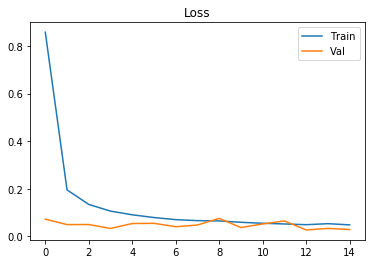

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['Train', 'Val'])
plt.title('Loss')

As the validation loss is still higher than the train loss it can be seen that the model is undergoing overfitting. 

However addition of the the new dropout layer after the 2nd MaxPooling layer our model now converges much better.

Text(0.5, 1.0, 'Accuracy')

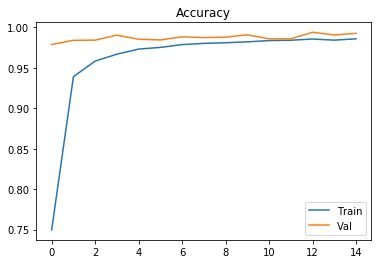

In [0]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['Train', 'Val'])
plt.title('Accuracy')

Again, our previous observation remain presistent.  The training accuracy is higher than our validation accuracy suggesting our model is overfitting the training dataset. 

However addition of the the new dropout layer after the 2nd MaxPooling layer our model now converges much better.

In [0]:
score = model.evaluate(X_test, y_test, verbose=1)

print('Test Score:', score[0]) 
print('Test Accuracy:', score[1])

12630/12630 [==============================] - 1s 68us/step
Test Score: 0.13854729359049073
Test Accuracy: 0.9739509105776759


# Prediction

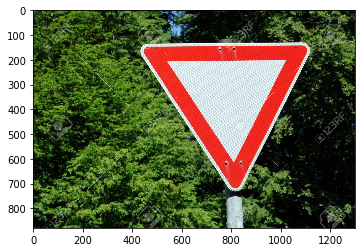

In [0]:
#fetch image

import requests
from PIL import Image

url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)
predicted sign: Class = 13 Name = Yield


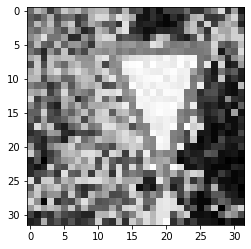

In [0]:
 #Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

#Reshape reshape

img = img.reshape(1, 32, 32, 1)

#Test image
prediction = model.predict_classes(img).item(0)
print("predicted sign: Class = "+ str(prediction) + " Name = " + str(np.array(label_names.loc[label_names['ClassId'] == prediction]).item(1)))


In [0]:
urls = ['https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg',
        'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg',
        'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg',
        'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg',
        'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg']


predictions = []

final_output = [1, 34, 23, 13, 29]

# Predictions 
for url in urls:
  r = requests.get(url, stream=True)
  img = Image.open(r.raw)
  # plt.imshow(img, cmap=plt.get_cmap('gray'))

   #Preprocess image

  img = np.asarray(img)
  img = cv2.resize(img, (32, 32))
  img = preprocessing(img)
  # plt.imshow(img, cmap = plt.get_cmap('gray'))
  # print(img.shape)

  #Reshape reshape

  img = img.reshape(1, 32, 32, 1)

  prediction = model.predict_classes(img)
  #Test image
  # print("predicted sign: "+ str(prediction))

  predictions.append(prediction.item(0))

i = 0
for prediction, actual in zip(predictions, final_output):
	if prediction == actual:
		i += 1

print(f"Successfully predicted {i}/{len(predictions)}")

Successfully predicted 3/5
